## Prepare parallel data

In [1]:
import pandas as pd
from nltk.tokenize.toktok import ToktokTokenizer
import nltk.data
import re

In [2]:
LINKS_CSV = 'src/links.csv'
FR_TSV = 'src/fra_sentences.tsv'
EN_TSV = 'src/eng_sentences.tsv'
EN_FR_TSV = 'src/Tatoeba_English-French-2021-03-24.tsv'

In [ ]:
#OPT1 - Read EN, FR and links separately
fr = pd.read_csv(FR_TSV, sep='\t', header=None, error_bad_lines=False)
fr = fr.rename(columns={0:'ID',1:'LANG',2:'TEXT'})

en = pd.read_csv(EN_TSV, sep='\t', header=None, error_bad_lines=False)
en = en.rename(columns={0:'ID',1:'LANG',2:'TEXT'})

links = pd.read_csv(LINKS_CSV, sep='\t', header=None, error_bad_lines=False)
links = links.rename(columns={0:'ID1',1:'ID2'})

#Merge to one parallel list
one = en[en['ID'].isin(links['ID1'])].copy()
two = fr[fr['ID'].isin(links['ID2'])].copy()

enfr = one.merge(two.merge(links,left_on='ID',right_on='ID2'),left_on='ID',right_on='ID1',suffixes=('1', '2'))
enfr = enfr.loc[:,~enfr.columns.duplicated()]
enfr.head()

In [3]:
#OPT2 - Read parallel file
enfr = pd.read_csv(EN_FR_TSV, sep='\t', header=None, error_bad_lines=False)
enfr = enfr.rename(columns={0:'ID1',1:'TEXT1',2:'ID2',3:'TEXT2'})

In [4]:
#Extract tokens
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer

tokenizer_en = nltk.data.load('tokenizers/punkt/english.pickle')
toktok = ToktokTokenizer()

def tokenize_en(string, to_lower = False):
    #apostrophe fix
    string = string.replace("`", "'")
    string = string.replace("’", "'")
    
    if to_lower:
        string = string.lower()
    string = string.strip()
    
    tokens = []
    
    for sent in tokenizer_en.tokenize(string):
        sent_tokens = [tok.replace("'","") for tok in toktok.tokenize(sent) if any(c.isalpha() for c in tok)]
        tokens.extend(sent_tokens)
    
    #sent_tokens = [tok.replace("'","") for tok in word_tokenize(string, language='english') if any(c.isalpha() for c in tok)]
    
    return tokens

def tokenize_fr(string, to_lower=False):
    #apostrophe fix
    string = string.replace("`", "'")
    string = string.replace("’", "'")
    
    if to_lower:
        string = string.lower()
    string = string.strip()
    
    tokens = word_tokenize(string, language='french')
    
    real_tokens = []
    for t in tokens:
        if any(c.isalpha() for c in t):
            subtokens = t.split("'")
            if len(subtokens) > 1:
                subtokens = [s + "'" for s in subtokens[:-1]] + [subtokens[-1]]
            real_tokens.extend(subtokens)

    
    return real_tokens
    
# def tokenize(string, to_lower = False, clear_nonalpha = False):
#     #apostrophe fix
#     string = string.replace("`", "'")
#     string = string.replace("’", "'")
    
#     tokens = []
#     if to_lower:
#         string = string.lower()
#     string = string.strip()

#     for sent in tokenizer_en.tokenize(string):
#         if clear_nonalpha:
#             sent_tokens = [tok for tok in toktok.tokenize(sent) if tok.isalpha()]
#         else:
#             sent_tokens = [tok for tok in toktok.tokenize(sent)]
        
#         tokens.extend(sent_tokens)
#     return tokens

In [5]:
enfr['WORDS1'] = enfr['TEXT1'].apply(lambda x: tokenize_en(x, True))
enfr['WORDS2'] = enfr['TEXT2'].apply(lambda x: tokenize_fr(x, True))

enfr['NOWORDS1'] = enfr['WORDS1'].apply(lambda x: len(x))
enfr['NOWORDS2'] = enfr['WORDS2'].apply(lambda x: len(x))

enfr_raw = enfr.copy() #backup original

print("%i parallel sents"%len(enfr))

enfr.head()

295583 parallel sents


,ID1,TEXT1,ID2,TEXT2,WORDS1,WORDS2,NOWORDS1,NOWORDS2
0,1276,Let's try something.,3091,Essayons quelque chose !,"[let, s, try, something]","[essayons, quelque, chose]",4,3
1,1276,Let's try something.,456963,Tentons quelque chose !,"[let, s, try, something]","[tentons, quelque, chose]",4,3
2,1277,I have to go to sleep.,373908,Je dois aller dormir.,"[i, have, to, go, to, sleep]","[je, dois, aller, dormir]",6,4
3,1280,Today is June 18th and it is Muiriel's birthday!,3095,Aujourd'hui nous sommes le 18 juin et c'est l'...,"[today, is, june, 18th, and, it, is, muiriel, ...","[aujourd', hui, nous, sommes, le, juin, et, c'...",10,13
4,1280,Today is June 18th and it is Muiriel's birthday!,696081,"Aujourd'hui c'est le 18 juin, et c'est l'anniv...","[today, is, june, 18th, and, it, is, muiriel, ...","[aujourd', hui, c', est, le, juin, et, c', est...",10,13


### Cleaning

In [6]:
#Tatoeba filtering
with open('etc/boynames_EN.txt', 'r') as f:
    boynames_en = [name[0:-1] for name in f.readlines()]
with open('etc/girlnames_EN.txt', 'r') as f:
    girlnames_en = [name[0:-1] for name in f.readlines()]
with open('etc/avoidlist_EN.txt', 'r') as f:
    avoidlist_en = [word[0:-1] for word in f.readlines()]
    
with open('etc/boynames_FR.txt', 'r') as f:
    boynames_fr = [name[0:-1] for name in f.readlines()]
with open('etc/girlnames_FR.txt', 'r') as f:
    girlnames_fr = [name[0:-1] for name in f.readlines()]
with open('etc/avoidlist_FR.txt', 'r') as f:
    avoidlist_fr = [word[0:-1] for word in f.readlines()]

MAX_COMMAS = 7
MAX_PERIOD = 4
MAX_QUOTE_EN = 4
MAX_QUOTE_FR = 2
MAX_TOKENS = 40
AVOID_CHAR = ['/', '\*', '<','₂','™','√','⊂','□','→','₫','=','>','\[','\]','\^','_','~', '§', '´', '‽']

In [7]:
# Filter sentences with bad chars
mask1 = enfr["TEXT1"].str.contains(r'(?:{})'.format('|'.join(AVOID_CHAR)))
mask2 = enfr["TEXT2"].str.contains(r'(?:{})'.format('|'.join(AVOID_CHAR)))
enfr = enfr[~mask1 & ~mask2]
print("Char cleaning:", len(enfr))

Char cleaning: 295512


In [8]:
# # Filter sentences with bad words
mask1 = enfr["TEXT1"].str.contains(r'\b(?:{})\b'.format('|'.join(avoidlist_en)))
mask2 = enfr["TEXT2"].str.contains(r'\b(?:{})\b'.format('|'.join(avoidlist_fr)))
enfr = enfr[~mask1 & ~mask2]
print("After bad word cleaning:", len(enfr))

After bad word cleaning: 288100


In [9]:
# Filter sentences that are like conversation and too long
def filter_length(row):
    if len(row['TEXT1'].split()) > MAX_TOKENS or \
       len(row['TEXT2'].split()) > MAX_TOKENS or \
       row['TEXT1'].count(',') > MAX_COMMAS or \
       row['TEXT2'].count(',') > MAX_COMMAS or \
       row['TEXT1'].count('. ') > MAX_PERIOD or \
       row['TEXT2'].count('. ') > MAX_PERIOD or \
       row['TEXT1'].count('"') > MAX_QUOTE_EN or \
       row['TEXT2'].count('"') > MAX_QUOTE_EN or \
       row['TEXT2'].count('«') > MAX_QUOTE_FR or \
      (row['TEXT1'].startswith('"') and row['TEXT1'].endswith('"')) or \
      (row['TEXT2'].startswith('«') and row['TEXT2'].endswith('»')):
#         print(row['TEXT1'])
#         print(row['TEXT2'])
#         print()
        return False

    return True

mask = enfr.apply(filter_length, axis=1)
enfr = enfr[mask]
print("After length filters:", len(enfr))

After length filters: 287020


In [10]:
import random

def diversify_names(row):
    if 'mary' in row["WORDS1"]:
        agirlname = girlnames_en[random.randint(0,len(girlnames_en) - 1)]
        
        row["TEXT1"] = row["TEXT1"].replace('Mary', agirlname)
        row["TEXT2"] = row["TEXT2"].replace('Mary', agirlname)
        
    if 'tom' in row["WORDS2"]:
        aboyname = boynames_en[random.randint(0,len(boynames_en) - 1)]
        row["TEXT1"] = row["TEXT1"].replace('Tom', aboyname)
        row["TEXT2"] = row["TEXT2"].replace('Tom', aboyname)

    return row

enfr = enfr.apply(diversify_names, axis=1)

### Read or write bigset from memory

In [11]:
#Write to file
enfr.to_csv('enfr.tsv', sep="\t")
enfr.to_pickle('enfr.pickle')

In [3]:
#Read from file
enfr = pd.read_pickle("enfr.pickle")

## Extract reference vocabulary

In [4]:
OPUS_VOCAB_EN = 'src/opus_en_50k.txt'
OPUS_VOCAB_FR = 'src/opus_fr_50k.txt'
REFERENCE_VOCAB_SIZE = 5000

In [5]:
def read_opus_vocab(vocab_file, size=None):
    vocab = pd.read_csv(vocab_file, sep=' ', header=None, error_bad_lines=False)
    vocab = vocab.rename(columns={0:'WORD',1:'COUNT'})
    
    vocab["FREQ"] = vocab["COUNT"] / vocab['COUNT'].sum()
    
    vocab.reset_index(inplace=True)

    if size: 
        vocab = vocab.head(size)
    return vocab

opus_vocab_en = read_opus_vocab(OPUS_VOCAB_EN, REFERENCE_VOCAB_SIZE)
opus_vocab_fr = read_opus_vocab(OPUS_VOCAB_FR, REFERENCE_VOCAB_SIZE)

In [6]:
print(len(opus_vocab_en))
opus_vocab_en.head()

5000


,index,WORD,COUNT,FREQ
0,0,you,22484400,0.042494
1,1,i,19975318,0.037752
2,2,the,17594291,0.033252
3,3,to,13200962,0.024949
4,4,a,11230036,0.021224


### Vocabulary analysis

In [7]:
def make_vocab(row, vocab, side="1"):
    for w in row["WORDS"+side]:
        vocab.add(w)
        
def analyze_vocab(vocab_set, reference_vocab_df, threshold):
    covered = reference_vocab_df.apply(lambda x:x["WORD"] in vocab_set, axis=1) 
    missing = ~covered

    no_covered = (covered[0:threshold]).value_counts()[1]
    no_missing = (covered[0:threshold]).value_counts()[0]
    
    print("Vocab size:", len(vocab_set))
    print("#Covered: %i (%.2f%%)"%(no_covered, no_covered/threshold * 100))
    print("#Missing: %i (%.2f%%)"%(no_missing, no_missing/threshold * 100))
    
    missing_df = reference_vocab_df[missing][reference_vocab_df[missing]["index"] < threshold]
    
    return missing_df

In [ ]:
print("=Complete set (enfr)=")
print("Size", len(enfr))

print("\n.English.")
vocab_bigset_en = set()
_ = enfr.apply(make_vocab, args=(vocab_bigset_en,), axis=1)
vocab_bigset_missing_en = analyze_vocab(vocab_bigset_en, opus_vocab_en, 5000)

print("\n.French.")
vocab_bigset_fr = set()
_ = enfr.apply(make_vocab, args=(vocab_bigset_fr,"2",), axis=1)
vocab_bigset_missing_fr = analyze_vocab(vocab_bigset_fr, opus_vocab_fr, 5000)

### Random sampling

In [ ]:
### Diversity scoring of sentences
enfr_random = enfr.sample(n=60000)
enfr_1k = enfr_random[0:1000].copy()
enfr_5k = enfr_random[0:5000].copy()
enfr_10k = enfr_random[5000:15000].copy()
enfr_15k = enfr_random[15000:30000].copy()
enfr_30k = enfr_random[30000:60000].copy()

In [ ]:
print("=Random set=")
s = enfr_30k

print("Size", len(s))

print("\n.English.")
vocab_en = set()
_ = s.apply(make_vocab, args=(vocab_en,), axis=1)
missing_en = analyze_vocab(vocab_en, opus_vocab_en, 5000)

print("\n.French.")
vocab_fr = set()
_ = s.apply(make_vocab, args=(vocab_fr,"2",), axis=1)
missing_fr = analyze_vocab(vocab_fr, opus_vocab_fr, 5000)

### Diversity sampling
Go word by word in vocabularies and sample from the bigset to a working set. 

In [8]:
from tqdm import tqdm
from nltk.corpus import stopwords
import csv
stopWords_en = set(stopwords.words('english'))
stopWords_fr = set(stopwords.words('french'))
tqdm.pandas()

In [50]:
set_size_to_reach = 30000

In [10]:
# Choose universal set to pick from
universal = enfr.copy()

In [51]:
# Read words already picked
picked_set = pd.read_pickle("picked.pickle")
bigset = universal.loc[universal.index.difference(picked_set.index)] # remove already picked
print("%i already picked"%len(picked_set))

30000 already picked


In [ ]:
# (If starting from scratch) initialize empty picked set
picked_set = pd.DataFrame(columns=bigset.columns)

In [52]:
# (For new set) Initialize empty working set
working_vocab_en = set()
working_vocab_fr = set()
working_set = pd.DataFrame(columns=bigset.columns)
couldnt_find_word_en = []
couldnt_find_word_fr = []

In [48]:
# To continue working on a set
working_set = pd.read_pickle("minikit.pickle")

In [50]:
# Filtering a pre-prepared set
#shit_sents = [403859,255737,3008457,663918,418877,321355,1356999,1152252,6479697,915564,1126115,470742,4545114,1533812,6901123,1183759,328604,592350,2441411,2158898,4443276,1392457,434306,1125593,696955,9035320,518410,632055,710980,2765416,1469180,799217,408712,329620,524515,629763,62026,8122907,1130113,1474763,838740,477377,7589503,941997,5789142,708881,1152184,6329336,691424,32058,777062,66859,865548,883876,779219,3874107,8846435,4261029,326773,6386085,281413,1074856,2888686]
shit_sents = []
working_set = working_set[~working_set["ID1"].isin(shit_sents)]
working_set = working_set.drop_duplicates(subset=['ID1']).drop_duplicates(subset=['ID2'])
print(len(working_set))

4998


In [55]:
# Fill-in with vocabulary coverage (English)
for w in tqdm(opus_vocab_en["WORD"]):
    if w not in stopWords_en:# and w not in working_vocab_en:
        #find sentences containing the word
        m = bigset["WORDS1"].apply(lambda x:w in x)
        
        #make sure it's not already in the working_set(check index, and sentence ids)
        sample_from = bigset.loc[bigset[m].index.difference(working_set.index)]
        duplicated = list(working_set[working_set["ID1"].isin(list(sample_from["ID1"].values))]["ID1"].values)
        sample_from = sample_from[~sample_from["ID1"].isin(duplicated)]
        duplicated = list(working_set[working_set["ID2"].isin(list(sample_from["ID2"].values))]["ID2"].values)
        sample_from = sample_from[~sample_from["ID2"].isin(duplicated)]
        
        if len(sample_from):
            #take random sentence
            some_sent = sample_from.sample(1)  #sampling size could be larger for more frequent words
            #append it to working_set
            working_set = working_set.append(some_sent)
            #update working vocabularies 
            working_vocab_en.update(some_sent["WORDS1"].item())
            working_vocab_fr.update(some_sent["WORDS2"].item())
            
            #TODO: To speed up, remove sent from bigset
            
            #stop when objective set size is reached
            if len(working_set) == set_size_to_reach:
                print("Set size reached before going over all vocabulary")
                break
        else:
            couldnt_find_word_en.append(w)
            
print("Current size:", len(working_set))

100%|██████████| 5000/5000 [08:54<00:00,  9.36it/s]

Current size: 8708


In [56]:
# Fill-in with vocabulary coverage (French)
for w in tqdm(opus_vocab_fr["WORD"]):
    if w not in stopWords_fr:# and w not in working_vocab_fr:
        #find sentences containing the word
        m = bigset["WORDS2"].apply(lambda x:w in x)
        
        #make sure it's not already in the working_set (check index, and sentence ids)
        sample_from = bigset.loc[bigset[m].index.difference(working_set.index)]
        duplicated = list(working_set[working_set["ID1"].isin(list(sample_from["ID1"].values))]["ID1"].values)
        sample_from = sample_from[~sample_from["ID1"].isin(duplicated)]
        duplicated = list(working_set[working_set["ID2"].isin(list(sample_from["ID2"].values))]["ID2"].values)
        sample_from = sample_from[~sample_from["ID2"].isin(duplicated)]
        
        if len(sample_from):
            #take random sentence
            some_sent = sample_from.sample(1)  #sampling size could be larger for more frequent words
            #append it to working_set
            working_set = working_set.append(some_sent)
            #update working vocabularies 
            working_vocab_en.update(some_sent["WORDS1"].item())
            working_vocab_fr.update(some_sent["WORDS2"].item())
            
            #stop when objective set size is reached
            if len(working_set) == set_size_to_reach:
                print("Set size reached before going over all vocabulary")
                break
        else:
            couldnt_find_word_fr.append(w)
            
print("Current size:", len(working_set))

100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]

Current size: 12954


In [59]:
len(fillin_sample)

7058

In [60]:
#fill in random (long) sentences 
print("Current size:", len(working_set))

fillin_sample = bigset[bigset["NOWORDS1"] > 8]

fillin_sample = fillin_sample.loc[fillin_sample.index.difference(working_set.index)]
duplicated = list(working_set[working_set["ID1"].isin(list(fillin_sample["ID1"].values))]["ID1"].values)
fillin_sample = fillin_sample[~fillin_sample["ID1"].isin(duplicated)]
duplicated = list(working_set[working_set["ID2"].isin(list(fillin_sample["ID2"].values))]["ID2"].values)
fillin_sample = fillin_sample[~fillin_sample["ID2"].isin(duplicated)]

fillin_sample = fillin_sample.sample(set_size_to_reach - len(working_set))
fillin_sample

Current size: 12954


,ID1,TEXT1,ID2,TEXT2,WORDS1,WORDS2,NOWORDS1,NOWORDS2
28928,239874,Salt was a rare and costly commodity in ancien...,8707,Le sel était une denrée rare et chère dans les...,"[salt, was, a, rare, and, costly, commodity, i...","[le, sel, était, une, denrée, rare, et, chère,...",10,12
238361,5715981,We don't have time to do that right now.,7007262,Nous n'avons pas le temps de faire cela mainte...,"[we, don, t, have, time, to, do, that, right, ...","[nous, n', avons, pas, le, temps, de, faire, c...",10,10
127909,2025959,You might want to take a look at this.,2026056,Il se pourrait que vous vouliez jeter un œil à...,"[you, might, want, to, take, a, look, at, this]","[il, se, pourrait, que, vous, vouliez, jeter, ...",9,11
14409,39973,Just a moment. I haven't made up my mind.,1476378,Juste un instant. Je ne me suis pas décidée.,"[just, a, moment, i, haven, t, made, up, my, m...","[juste, un, instant, je, ne, me, suis, pas, dé...",10,9
112038,1773003,"I have heard the mermaids singing, each to eac...",1773333,J'ai entendu les sirènes se chanter l'une à l'...,"[i, have, heard, the, mermaids, singing, each,...","[j', ai, entendu, les, sirènes, se, chanter, l...",19,22
35228,255817,I cannot put up with his idleness any longer.,6877,Je ne peux supporter son oisiveté plus longtemps.,"[i, cannot, put, up, with, his, idleness, any,...","[je, ne, peux, supporter, son, oisiveté, plus,...",9,8
57110,314157,She wouldn't allow me to read the letter.,1828287,Elle ne voulait pas me permettre de lire la le...,"[she, wouldn, t, allow, me, to, read, the, let...","[elle, ne, voulait, pas, me, permettre, de, li...",9,10
36417,258415,I'm not in the least afraid of snakes.,727336,Je n'ai pas du tout peur des serpents.,"[i, m, not, in, the, least, afraid, of, snakes]","[je, n', ai, pas, du, tout, peur, des, serpents]",9,9
206453,5688153,I like my life the way it is now.,5688201,J'aime ma vie telle qu'elle est à présent.,"[i, like, my, life, the, way, it, is, now]","[j', aime, ma, vie, telle, qu', elle, est, à, ...",9,10
25680,69290,You are the most important person of us all.,1174417,Tu es la personne la plus importante de nous t...,"[you, are, the, most, important, person, of, u...","[tu, es, la, personne, la, plus, importante, d...",9,10


In [61]:
#Add fillin sample
working_set = pd.concat([working_set, fillin_sample])

print("added", len(fillin_sample))
print("Final size:", len(working_set))

added 17046
Final size: 30000


In [62]:
print("=Working set=")
s = working_set

print("Size", len(s))

print("\n.English.")
vocab_en = set()
_ = s.apply(make_vocab, args=(vocab_en,), axis=1)
missing_en = analyze_vocab(vocab_en, opus_vocab_en, 5000)

word_counts = s.apply(lambda x:len(x["TEXT1"].split()), axis=1)
print("Avg. words:", word_counts.mean())
print("Total words:", word_counts.sum())

print("\n.French.")
vocab_fr = set()
_ = s.apply(make_vocab, args=(vocab_fr,"2",), axis=1)
missing_fr = analyze_vocab(vocab_fr, opus_vocab_fr, 5000)

word_counts = s.apply(lambda x:len(x["TEXT2"].split()), axis=1)
print("Avg. words:", word_counts.mean())
print("Total words:", word_counts.sum())

=Working set=
Size 30000

.English.
Vocab size: 12291
#Covered: 4411 (88.22%)
#Missing: 589 (11.78%)
Avg. words: 8.4931
Total words: 254793

.French.
Vocab size: 17235
#Covered: 4488 (89.76%)
#Missing: 512 (10.24%)
Avg. words: 8.970333333333333
Total words: 269110


In [63]:
#Save to files
settag = 'largekit'

#Add working set to picked set
picked_set = pd.concat([picked_set, working_set], axis=0)
picked_set = picked_set[~picked_set.index.duplicated()]
print("Picked set: %i"%(len(picked_set)))

#save set
working_set.to_csv(settag + ".tsv",index=False, sep="\t", header=False, quoting=csv.QUOTE_NONE, columns = ['ID1','TEXT1', 'ID2','TEXT2'])
working_set.to_csv(settag + "_en.csv",index=False, sep="\t", header=False, quoting=csv.QUOTE_NONE, columns = ['TEXT1'])
working_set.to_csv(settag + "_fr.csv",index=False, sep="\t", header=False, quoting=csv.QUOTE_NONE, columns = ['TEXT2'])
working_set.to_excel(settag + ".xlsx", index=False, sheet_name="Sheet1", columns = ['ID1','TEXT1', 'ID2','TEXT2'])
working_set.to_pickle(settag + ".pickle")

#save updated picked sentence ids
#Write to file
picked_set.to_csv('picked.tsv', sep="\t", columns = ['ID1','TEXT1', 'ID2','TEXT2'])
picked_set.to_pickle('picked.pickle')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


Picked set: 60000


### Plot histogram

In [66]:
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Frequency'>

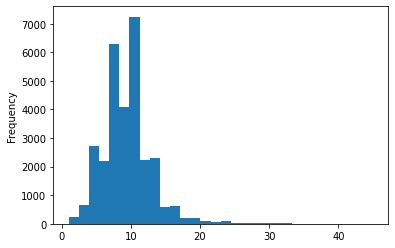

In [67]:
plt.figure()
working_set["NOWORDS2"].plot.hist(bins=30)

### Get revised translations from table
Pre - Load working set (kit)

In [73]:
dupdrop = working_set.drop_duplicates(subset=['ID1']).drop_duplicates(subset=['ID2'])

In [15]:
#Get sentence revisions from file
revision_table = pd.read_excel("minikit_EN-FR_v2alpha_Revisé-CT-ATT.xlsx")

In [95]:
def revise(row):
    try:
        in_working_set = row["TEXT2"]
        in_revised_set = revision_table[revision_table["ID2"] == row["ID2"]]["TEXT2"].head(1)
        if len(in_revised_set) and not in_working_set == in_revised_set.item():
            print("<<<", in_working_set)
            print(">>>", in_revised_set.item())
            print()
            row["TEXT2"] = in_revised_set.item()
    except Exception as e:
        print(e)
        print(row)
    return row

working_set = working_set.apply(revise, axis=1)

### Play

array([[<AxesSubplot:title={'center':'index'}>]], dtype=object)

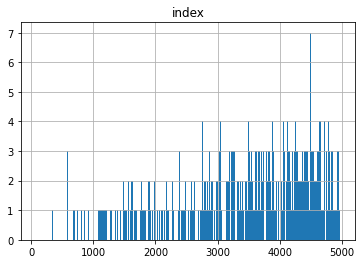

In [64]:
missing_en.hist(column='index', bins=500)

In [65]:
missing_en[missing_en['index'] < 2000]#[missing_en['index'] > 1000]

,index,WORD,COUNT,FREQ
73,73,l,1158454,0.002189
283,283,huh,205097,0.000388
328,328,fucking,179076,0.000338
341,341,um,172992,0.000327
524,524,whoa,100036,0.000189
573,573,ass,85445,0.000161
589,589,bitch,81395,0.000154
590,590,ha,80811,0.000153
592,592,sighs,80364,0.000152
630,630,hmm,73706,0.000139
